In [ ]:
# Import dependencies
import os as os
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow import keras 
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Link google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define directories (adapt to your own path)
dirAudio = "/content/drive/MyDrive/ColabNotebooks/ASR_Python/Datasets/Event_dataset/Audio_data"
dirFeats = "/content/drive/MyDrive/ColabNotebooks/ASR_Python/Feat_data"
if not os.path.isdir(dirFeats):
      os.makedirs(dirFeats)

Data Augmentation

---



---


Ref: https://github.com/iver56/audiomentations

In [ ]:
#install the audiomentations package
!pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.6 MB/s 


In [ ]:
#import required functions from audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from tqdm import tqdm

#compose required audio event augmentations
#for more explanations refer the reference source page
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),#add noise
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),#stretch the event in time
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),#change the pitch
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),#shift the position of the audio event
])
#number of augmented copies to be generated
N_copies = 10

In [ ]:
# go through each audio file in the folder and generate augmented copies
for file_ in tqdm(os.listdir(dirAudio)):
  for n in tqdm(range(N_copies)):
    # Read the audio data
    data, samplerate = sf.read(os.path.join(dirAudio, file_))
    if data.shape[1] >=2:
      data = data[:,1]
    # Give error if samplerate is different from featconf['samFreq']
    #assert samplerate == featconf['samFreq'], "Samplerate of the .wav file differs from the feature configuration!"
    # Augment/transform/perturb the audio data
    augmented_samples = augment(samples=data, sample_rate=samplerate)
    #save the data
    out_file_ = file_[:-4] + '_' + str(n) + '.WAV'
    sf.write(os.path.join(dirAudio, out_file_), augmented_samples, samplerate=samplerate)



  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/audiomentations/core/transforms_interface.py:58: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  "Warning: input samples dtype is np.float64. Converting to np.float32"

 10%|█         | 1/10 [00:03<00:34,  3.87s/it]/usr/local/lib/python3.7/dist-packages/audiomentations/core/transforms_interface.py:58: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  "Warning: input samples dtype is np.float64. Converting to np.float32"

 70%|███████   | 7/10 [00:02<00:01,  2.59it/s]/usr/local/lib/python3.7/dist-packages/audiomentations/core/transforms_interface.py:58: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  "Warning: input samples dtype is np.float64. Converting to np.float32"

100%|██████████| 40/40 [02:01<00:00,  3.03s/it]


Frequency Domain augmentation : Augmentation on the spec

Method: Spec Augment: ref: https://arxiv.org/abs/1904.08779
Reference implementation: https://github.com/DemisEom/SpecAugment

In [ ]:
# Configuration for spec augment:
# Follow the reference for definition of each component.
spec_augment_offline_configuration = {
    'mask_fraction_min':0.01,
    'mask_fraction_max':0.02,
    'mask_fraction_min_time':0.01,
    'mask_fraction_max_time':0.02,
    'p_spec_augment':0.5,
    'fill_val':0,
    'num_freq_lines':3,
    'num_time_lines':3,
    'time_warping_para':10
}

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 26.6 MB/s 


In [ ]:

from tensorflow_addons.image import sparse_image_warp
import random


def sparse_warp(mel_spectrogram, time_warping_para=10):
    '''
      mel_spectrogram: 2d mel spectrogram of size n*v, with n being the number of time frames and v being the number of mel frequency bins.
      time_warping_para: parameter for time warping.
    '''
    #resize to make it compatible with rest of the code
    mel_spectrogram = np.reshape(mel_spectrogram, (-1, mel_spectrogram.shape[0], mel_spectrogram.shape[1], 1))


    fbank_size = tf.shape(mel_spectrogram)
    n, v = fbank_size[1], fbank_size[2]

    # Step 1 : Time warping
    # Image warping control point setting.
    # Source
    pt = tf.random.uniform([], time_warping_para, n-time_warping_para, tf.int32) # radnom point along the time axis
    src_ctr_pt_freq = tf.range(v // 2)  # control points on freq-axis
    src_ctr_pt_time = tf.ones_like(src_ctr_pt_freq) * pt  # control points on time-axis
    src_ctr_pts = tf.stack((src_ctr_pt_time, src_ctr_pt_freq), -1)
    src_ctr_pts = tf.cast(src_ctr_pts, dtype=tf.float32)

    # Destination
    w = tf.random.uniform([], -time_warping_para, time_warping_para, tf.int32)  # distance
    dest_ctr_pt_freq = src_ctr_pt_freq
    dest_ctr_pt_time = src_ctr_pt_time + w
    dest_ctr_pts = tf.stack((dest_ctr_pt_time, dest_ctr_pt_freq), -1)
    dest_ctr_pts = tf.cast(dest_ctr_pts, dtype=tf.float32)

    # warp
    source_control_point_locations = tf.expand_dims(src_ctr_pts, 0)  # (1, v//2, 2)
    dest_control_point_locations = tf.expand_dims(dest_ctr_pts, 0)  # (1, v//2, 2)

    warped_image, _ = sparse_image_warp(mel_spectrogram,
                                        source_control_point_locations,
                                        dest_control_point_locations)
    warped_image = warped_image[0,:,:,0].numpy()
    return warped_image



def spec_augment_offline(spectrogram, configuration):
  '''
      mel_spectrogram: 2d mel spectrogram of size n*v, with n being the number of time frames and v being the number of mel frequency bins.
      configuration: dictionary with different parameters for spec augment.  
  '''
  # Spec Augmentation
  width, height = spectrogram.shape

  h_percentage = np.random.uniform(low=configuration['mask_fraction_min'], high=configuration['mask_fraction_max'],size=configuration['num_freq_lines'])
  w_percentage = np.random.uniform(low=configuration['mask_fraction_min_time'], high=configuration['mask_fraction_max_time'], size=configuration['num_time_lines'])
  #print(h_percentage, w_percentage)

  #copy of the spectrogram
  new_input = spectrogram.copy()

  # Step1: Time warping
  new_input = sparse_warp(new_input.astype('float32'), time_warping_para=configuration['time_warping_para'])

  # Step2: loop for the number of lines of frequency masking
  for i in range(configuration['num_freq_lines']):
    if 1:#random.random() < configuration['p_spec_augment']:
        h_mask = int(np.ceil(h_percentage[i] * height))
        h = int(np.ceil(np.random.uniform(0.0, height - h_mask)))
        #print(h_percentage[i],h,h_mask)
        new_input[:, h:h + h_mask] = configuration['fill_val']#fill with mask value

  # Step3: loop for the number of lines of time masking
  for j in range(configuration['num_time_lines']):
    if 1:#random.random() < configuration['p_spec_augment']:
        w_mask = int(np.ceil(w_percentage[j] * width))
        w = int(np.ceil(np.random.uniform(0.0, width - w_mask)))
        #print(w_percentage[j],w, w_mask)
        new_input[w:w + w_mask,:] = configuration['fill_val']#fill with mask value

  return new_input

In [ ]:
#example usage
spectrogram = np.load(os.path.join(dirFeats,'handclap_06.npy'))
print(spectrogram.shape)

(497, 64)


In [ ]:
spectrogram_augmented  = spec_augment_offline(spectrogram, spec_augment_offline_configuration)
print(spectrogram_augmented.shape)

(497, 64)


Text(0.5, 1.0, 'spectrogram_augmented')

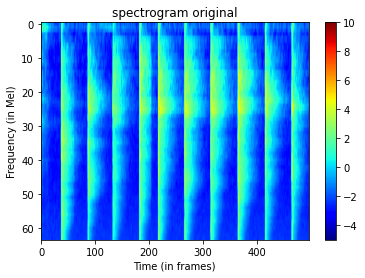

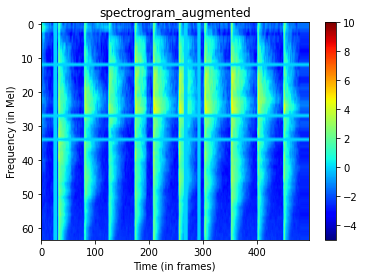

In [ ]:
  #plot original spectrogram
  plt.figure()
  plt.imshow(spectrogram.T, cmap='jet', aspect='auto', clim=[-5, 10])
  plt.colorbar()
  plt.xlabel('Time (in frames)')
  plt.ylabel('Frequency (in Mel)')
  plt.title('spectrogram original')

#plot the augmented spectrogram
  plt.figure()
  plt.imshow(spectrogram_augmented.T, cmap='jet', aspect='auto', clim=[-5, 10])
  plt.colorbar()
  plt.xlabel('Time (in frames)')
  plt.ylabel('Frequency (in Mel)')
  plt.title('spectrogram_augmented')

End of data augmentation demo

In [ ]:
# Define dataset configuration parameters
datasetconf = {}
datasetconf['classNames'] = ['background', 'handclap', 'speech', 'whistle']

In [ ]:
# Import the custom feature extraction code (stored on Google drive)
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/ASR_Python/FE_funcs')
from feat_extract import FE

In [ ]:
# Define feature extraction parameters
featconf = {}
featconf['dcRemoval'] = 'hpf'
featconf['samFreq'] = 32000
featconf['lowFreq'] = 0
featconf['highFreq'] = featconf['samFreq']/2
featconf['stepSize_ms'] = 10
featconf['frameSize_ms'] = 32
featconf['melSize'] = 64

In [ ]:
# Crete a FE (featextract) class
featextract = FE(featconf)

# Create list to save the features and labels
X, Y = [], []

# Extract the features file per file
for file in os.listdir(dirAudio):
  if not os.path.isfile(os.path.join(dirFeats, file.replace('.WAV', '.npy'))):
        # Print output status
        print('Extract {file}'.format(file=file))
        # Read the audio data
        data, samplerate = sf.read(os.path.join(dirAudio, file))
        if data.ndim >=2:
          data = data[:,1]
        # Give error if samplerate is different from featconf['samFreq']
        assert samplerate == featconf['samFreq'], "Samplerate of the .wav file differs from the feature configuration!"
        # Extract and save the features
        logmelframes = featextract.fe_transform(data)
        np.save(os.path.join(dirFeats, file.replace('.WAV', '.npy')), logmelframes)
        # Get the label
        label = [i for i,x in enumerate(datasetconf['classNames']) if x == file.split('_')[0]]
        # Create and save a figure of the features
        plt = featextract.create_plot(logmelframes, file)
        plt.savefig(os.path.join(dirFeats, file.replace('.WAV', '.png')))
        plt.close()
        # Store the features and labels
        X.append(logmelframes)
        Y.append(label[0])
  else:
        # Print output status
        print('Load {file}'.format(file=file.replace('.WAV', '.npy')))
        # Load the feature file
        logmelframes = np.load(os.path.join(dirFeats, file.replace('.WAV', '.npy')))
        # Get the label
        label = [i for i,x in enumerate(datasetconf['classNames']) if x == file.split('_')[0]]
        # Store the features and labels
        X.append(logmelframes)
        Y.append(label[0])

# Convert to numpy
X = np.asarray(X)
Y = np.asarray(Y)

Load background_01.npy
Load background_06.npy
Load speech_05.npy
Load whistle_01.npy
Load speech_03.npy
Load speech_04.npy
Load handclap_07.npy
Load handclap_08.npy
Load handclap_10.npy
Load whistle_05.npy
Load background_02.npy
Load speech_01.npy
Load speech_06.npy
Load background_08.npy
Load background_05.npy
Load speech_02.npy
Load speech_07.npy
Load handclap_04.npy
Load handclap_02.npy
Load background_09.npy
Load speech_08.npy
Load whistle_08.npy
Load whistle_09.npy
Load speech_10.npy
Load whistle_07.npy
Load handclap_09.npy
Load whistle_02.npy
Load handclap_01.npy
Load background_03.npy
Load background_04.npy
Load whistle_04.npy
Load background_07.npy
Load handclap_05.npy
Load whistle_06.npy
Load background_10.npy
Load whistle_10.npy
Load whistle_03.npy
Load speech_09.npy
Load handclap_03.npy
Load handclap_06.npy
Extract background_01_0.WAV
Extract background_01_1.WAV
Extract background_01_2.WAV
Extract background_01_3.WAV
Extract background_01_4.WAV
Extract background_01_5.WAV
Ex

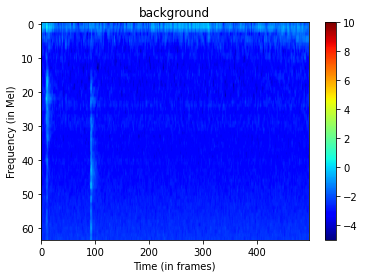

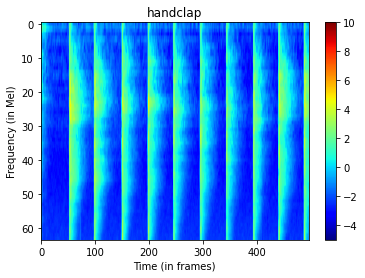

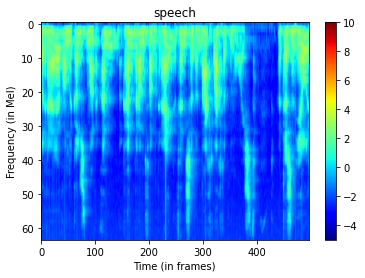

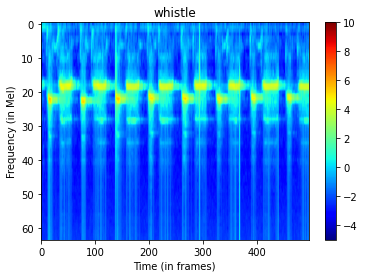

In [ ]:
# Visualise sample of each class
for i, className in enumerate(datasetconf['classNames']):
  plt.figure()
  plt.imshow(X[np.where(i==Y)[0][0], :, :].T, cmap='jet', aspect='auto', clim=[-5, 10])
  plt.colorbar()
  plt.xlabel('Time (in frames)')
  plt.ylabel('Frequency (in Mel)')
  plt.title(datasetconf['classNames'][i])

In [ ]:
# Normalise the features
[X, mu, sigma] = featextract.normalise_data(X)

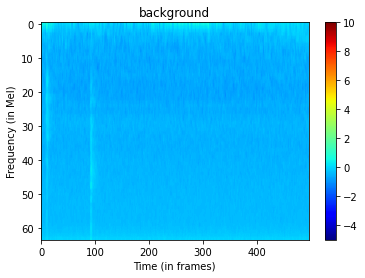

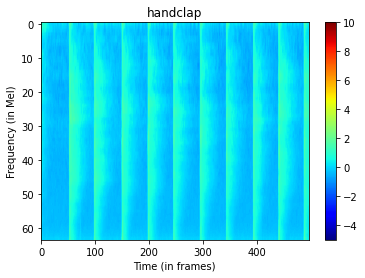

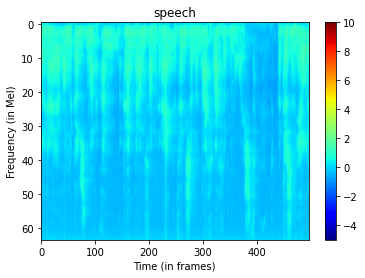

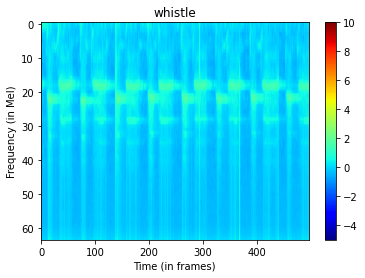

In [ ]:
# Visualise normalized sample of each class
for i, className in enumerate(datasetconf['classNames']):
  plt.figure()
  plt.imshow(X[np.where(i==Y)[0][0], :, :].T, cmap='jet', aspect='auto', clim=[-5, 10])
  plt.colorbar()
  plt.xlabel('Time (in frames)')
  plt.ylabel('Frequency (in Mel)')
  plt.title(datasetconf['classNames'][i])

In [ ]:
# Create segments of 50 frames
segSize = 50

# Create lists to store the segments
X_seg, Y_seg = [], []

# Loop over the data

for n in range(0, np.shape(X)[0]):
        
        # Take the corresponding sample
        X_n = X[n]
        Y_n = Y[n]

        # Compute the number of frames that must be padded
        numseg = int(np.ceil(np.shape(X_n)[0]/segSize))
        numframes = int(numseg*segSize-np.shape(X_n)[0])

        # Take the first numframes samples again for extra data to complete the segment
        extra_data = X_n[0:numframes,:]

        # Add the extra frames
        X_n = np.concatenate((X_n, extra_data))

        # Reshape the data matrix and label matrix
        X_n = np.reshape(X_n,[numseg, segSize, np.shape(X_n)[1]])
        Y_n = np.ones(numseg)*Y_n


        # Add to X_seg and Y_seg
        if n == 0:
          X_seg = X_n
          Y_seg = Y_n
        else:
          X_seg = np.concatenate((X_seg, X_n), axis=0)
          Y_seg = np.concatenate((Y_seg, Y_n), axis=0)

In [ ]:
# Create training, validation and test set (50% train, 25% val, 25% test)
[X_tr, X_val, X_te, Y_tr, Y_val, Y_te] = featextract.create_tr_val_te(X_seg, Y_seg, [0.5, 0.25, 0.25])
# Add channel axis
[X_tr, X_val, X_te] = featextract.add_channel_axis(X_tr, X_val, X_te)

Online Data Augmentation example

Earlier, we saw created augmented copies of the audio event and stored them.
Using the Online data augmentation (spec-augment library : https://pypi.org/project/spec-augment/), we will specify augmentation as part of the model layer. This will augment the inputs on the fly during training based  on the set parameters. The augmentation method used here is called SpecAugment.

In [ ]:
## install spec_augment
!pip install spec-augment
from spec_augment import SpecAugment
#spec_augment can be used as an keras layer in the model.
spec_augment = SpecAugment(freq_mask_param=5,
                           time_mask_param=10,
                           n_freq_mask=3,
                           n_time_mask=3,
                           mask_value=0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
Enable_online_augmentation = False#set this to True to enable.

Build the model

In [ ]:
# Define model
model = keras.Sequential()
if Enable_online_augmentation:
  model.add(spec_augment)
# First convolutional layer
model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=regularizers.L2(0.01), input_shape=(np.shape(X_tr)[1], np.shape(X_tr)[2], 1), name='conv1'))
model.add(layers.Activation('relu', name='relu1'))
model.add(layers.MaxPooling2D(pool_size=(1, 4), name='pool1'))
model.add(layers.Dropout(0.5, name='drop1'))
# Second convolutional layer
model.add(layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=regularizers.L2(0.01), name='conv2'))
model.add(layers.Activation('relu', name='relu2'))
model.add(layers.MaxPooling2D(pool_size=(1, 4), name='pool2'))
model.add(layers.Dropout(0.5, name='drop2'))
# Third convolutional layer
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=regularizers.L2(0.01), name='conv3'))
model.add(layers.Activation('relu', name='relu3'))
model.add(layers.MaxPooling2D(pool_size=(1, 4), name='pool3'))
model.add(layers.Dropout(0.5, name='drop3'))
# Flatten layer
model.add(layers.Flatten(name='flatten1'))
# First dense layer
model.add(layers.Dense(16, kernel_regularizer=regularizers.L2(0.01), name='fc1'))
model.add(layers.Activation('relu', name='relu4'))
model.add(layers.Dropout(0.2, name='drop4'))
# Output layer
model.add(layers.Dense(len(datasetconf['classNames']), kernel_regularizer=regularizers.L2(0.01), name='main_out'))
model.add(layers.Activation('softmax', name='softmax1'))
# Define the compiler
adamOwn = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
# Compile the model
if Enable_online_augmentation:
  model.build((None, np.shape(X_tr)[1], np.shape(X_tr)[2], 1))
model.compile(optimizer=adamOwn, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
# Print the model summary

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 50, 64, 64)        1664      
                                                                 
 relu1 (Activation)          (None, 50, 64, 64)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 50, 16, 64)        0         
                                                                 
 drop1 (Dropout)             (None, 50, 16, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 50, 16, 32)        51232     
                                                                 
 relu2 (Activation)          (None, 50, 16, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 4, 32)         0

In [ ]:
# Train the model
model_log = model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val), batch_size=32, epochs=50, verbose=1)

Epoch 1/50
69/69 [==============================] - 13s 32ms/step - loss: 2.1937 - accuracy: 0.3505 - val_loss: 1.8701 - val_accuracy: 0.4682
Epoch 2/50
69/69 [==============================] - 1s 15ms/step - loss: 1.2918 - accuracy: 0.7059 - val_loss: 0.7782 - val_accuracy: 0.9036
Epoch 3/50
69/69 [==============================] - 1s 12ms/step - loss: 0.7180 - accuracy: 0.9095 - val_loss: 0.5201 - val_accuracy: 0.9600
Epoch 4/50
69/69 [==============================] - 1s 13ms/step - loss: 0.5626 - accuracy: 0.9355 - val_loss: 0.4518 - val_accuracy: 0.9673
Epoch 5/50
69/69 [==============================] - 1s 15ms/step - loss: 0.4766 - accuracy: 0.9523 - val_loss: 0.3832 - val_accuracy: 0.9736
Epoch 6/50
69/69 [==============================] - 1s 12ms/step - loss: 0.4189 - accuracy: 0.9559 - val_loss: 0.3491 - val_accuracy: 0.9782
Epoch 7/50
69/69 [==============================] - 1s 9ms/step - loss: 0.3695 - accuracy: 0.9609 - val_loss: 0.3035 - val_accuracy: 0.9764
Epoch 8/50
69

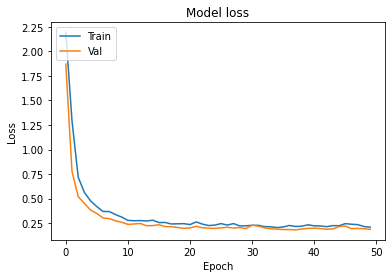

In [ ]:
# Plot the model log
plt.figure()
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

In [ ]:
# Do a prediction on the test samples
Y_te_hat = model.predict(X_te)

# Create classification report
cr = classification_report(Y_te, np.argmax(Y_te_hat, axis=1), target_names=datasetconf['classNames'])
print(cr)

# Create confusion matrix
cm = confusion_matrix(Y_te, np.argmax(Y_te_hat, axis=1))  
print(cm)

35/35 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

  background       0.95      1.00      0.97       275
    handclap       0.99      0.96      0.98       275
      speech       1.00      0.98      0.99       275
     whistle       1.00      0.99      1.00       275

    accuracy                           0.98      1100
   macro avg       0.98      0.98      0.98      1100
weighted avg       0.98      0.98      0.98      1100

[[275   0   0   0]
 [ 11 264   0   0]
 [  3   2 270   0]
 [  2   0   0 273]]


In [ ]:
# Do a prediction on the test samples
Y_te_hat = model.predict(X_te)

# Create classification report
cr = classification_report(Y_te, np.argmax(Y_te_hat, axis=1), target_names=datasetconf['classNames'])
print(cr)

# Create confusion matrix
cm = confusion_matrix(Y_te, np.argmax(Y_te_hat, axis=1))  
print(cm)

35/35 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

  background       0.95      1.00      0.97       275
    handclap       0.99      0.96      0.98       275
      speech       1.00      0.98      0.99       275
     whistle       1.00      0.99      1.00       275

    accuracy                           0.98      1100
   macro avg       0.98      0.98      0.98      1100
weighted avg       0.98      0.98      0.98      1100

[[275   0   0   0]
 [ 11 264   0   0]
 [  3   2 270   0]
 [  2   0   0 273]]


In [ ]:
Y_te_hat

array([[9.9876887e-01, 7.3440501e-04, 3.4939169e-04, 1.4728348e-04],
       [9.9606329e-01, 2.2610009e-03, 1.1427159e-03, 5.3298415e-04],
       [9.9842465e-01, 9.0464653e-04, 4.6993914e-04, 2.0076577e-04],
       [9.9830973e-01, 1.0046567e-03, 4.7838883e-04, 2.0716076e-04],
       [9.9888104e-01, 6.5425114e-04, 3.2645770e-04, 1.3825302e-04],
       [9.9869460e-01, 7.8944908e-04, 3.6384072e-04, 1.5210042e-04],
       [9.9861062e-01, 8.4170752e-04, 3.8492211e-04, 1.6264265e-04],
       [9.9810165e-01, 1.0544914e-03, 5.8270764e-04, 2.6107239e-04],
       [9.7415835e-01, 1.7688647e-02, 5.4395753e-03, 2.7134803e-03],
       [9.8444611e-01, 8.8445991e-03, 4.6279402e-03, 2.0813216e-03],
       [6.9915169e-01, 5.1815316e-02, 2.0080070e-01, 4.8232317e-02],
       [6.1535921e-02, 9.6540470e-03, 8.9391756e-01, 3.4892432e-02],
       [9.9692267e-01, 1.6905335e-03, 9.4623491e-04, 4.4056526e-04],
       [2.5676681e-09, 1.0000000e+00, 2.3738070e-10, 3.4703510e-10],
       [6.0886953e-09, 1.0000000e+